# main

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':30,
    'ytick.labelsize':30,
    'axes.labelsize':40,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = '../data.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Winter meeting figures

In [4]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

In [5]:
uM = np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).max()
uM

np.float64(0.003302595359836294)

In [6]:
def fluidOverview(df):
    df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    # figure preparation
    fig, axes = plt.subplots(2, 1, figsize = (9,9))
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)

    # first plot
    upperLim = 1
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes[0].streamplot(X, Y, 
        df.fluidVelocity_x.unstack().values.transpose(),
        df.fluidVelocity_y.unstack().values.transpose(),
        density=0.85, linewidth=1, color="black",
    )
    
    
    axes[0].pcolormesh(X, Y,
        (np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2)/uM).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
    axes[0].tick_params(labelbottom=False)
    axes[0].set_xticks([-20, 0, 20])
    axes[0].set_yticks([-10, 0, 10])

    # Create a mask as a filled polygon (circle patch with alpha for masking)
    myColor='#F7F7F7'
    mask = Circle((-5.0, 0.0), 1, transform=axes[0].transData, color=myColor, linestyle='', alpha=1, zorder=2)
    axes[0].add_patch(mask)
    
    cbar_ax = fig.add_axes([0.9, 0.55, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}/u_\\mathrm{max}$')

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in custom_ticks])
    
    # bottom plot
    upperLim = 1.01
    lowerLim = 0.99
    cmap = plt.get_cmap('seismic')
    norm = plt.Normalize(lowerLim, upperLim)
    axes[1].pcolormesh(X,Y,
        df.massDensity.unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap,
    );
    axes[1].set_xticks([-20, 0, 20])
    axes[1].set_xlabel("$x ~ (\\mu \\mathrm{m})$")
    axes[1].set_yticks([-10, 0, 10])

    # Create a mask as a filled polygon (circle patch with alpha for masking)
    mask = Circle((-5.0, 0.0), 1, transform=axes[1].transData, color=myColor, linestyle='', alpha=1, zorder=2)
    axes[1].add_patch(mask)
    
    fig.text(-0.01, 0.5, '$y ~ (\\mu \\mathrm{m})$', va='center', ha='center', rotation='vertical', fontsize=40)

    cbar_ax = fig.add_axes([0.9, 0.13, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(label='$\\rho/\\rho_0$')

    custom_ticks = np.array([lowerLim, 1 ,upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(custom_ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in custom_ticks])
    
    return fig, axes

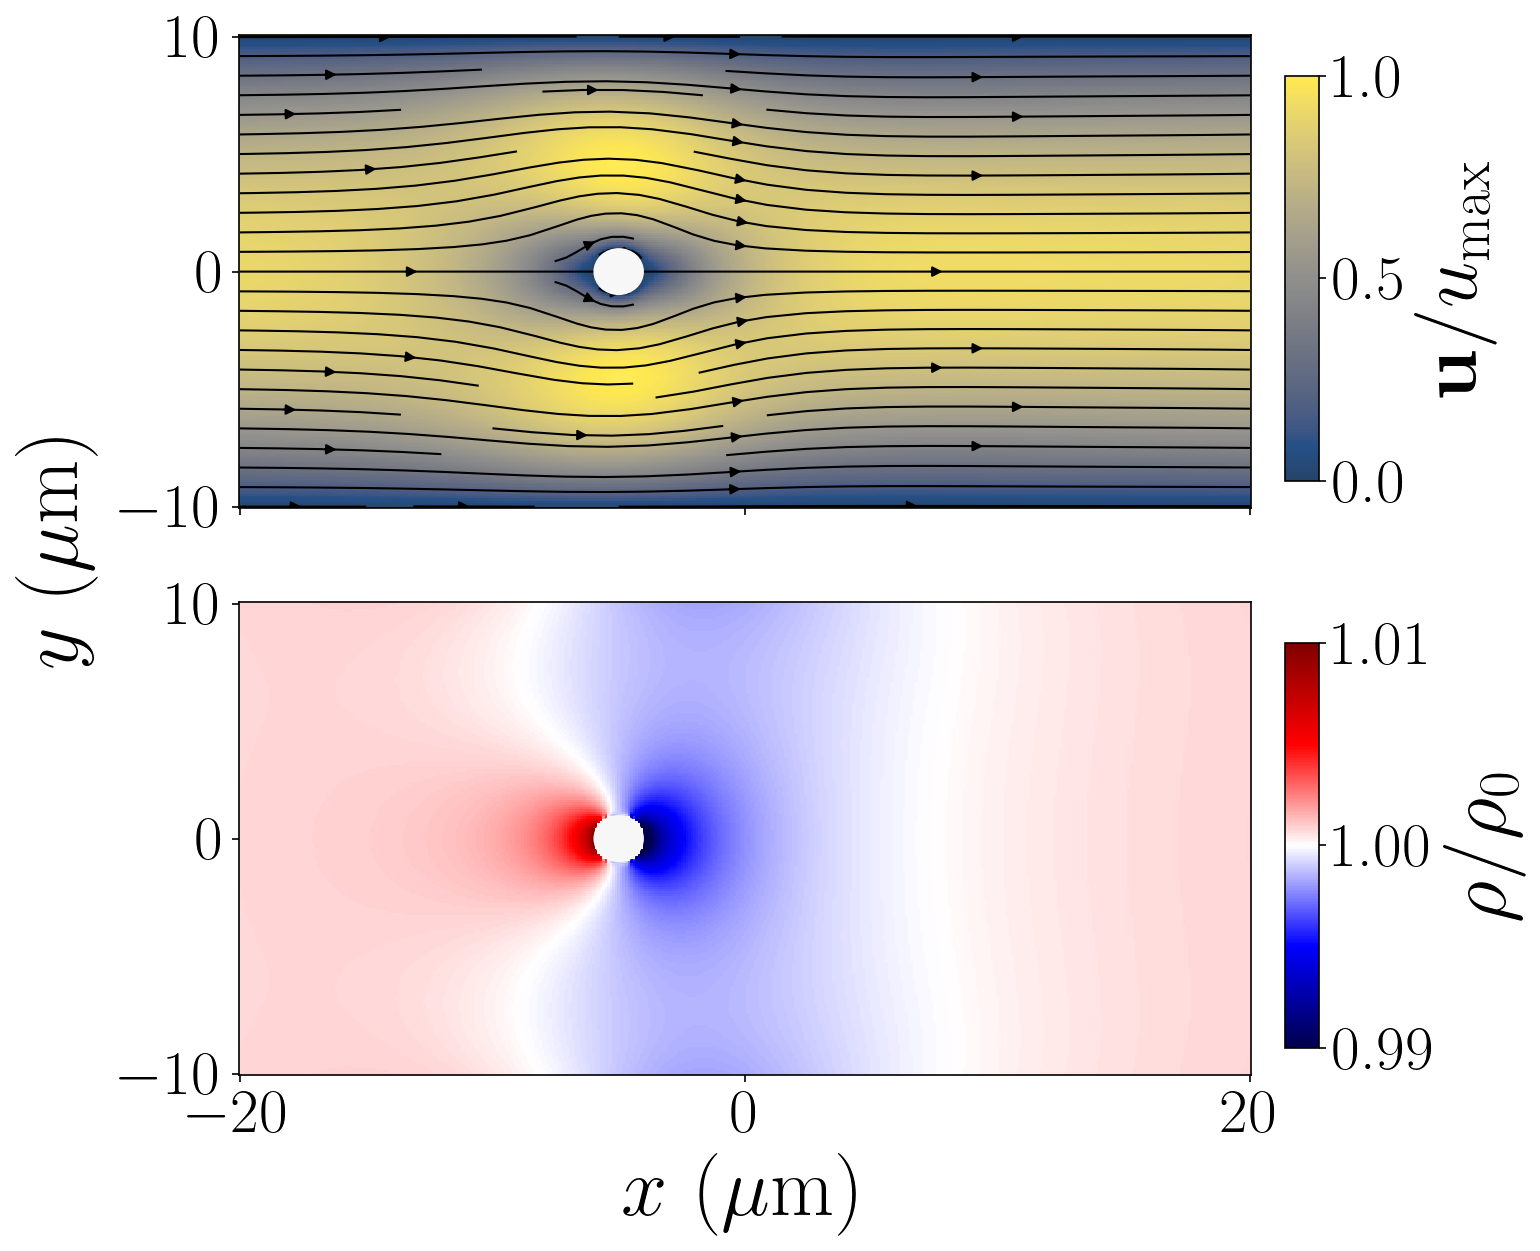

In [7]:
fig, axes = fluidOverview(fluidDf)
plt.savefig("figs/figure1.png", format="png", transparent=True, dpi=72, bbox_inches="tight")
plt.savefig("figs/figure1hd.png", format="png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

# Stability analysis

In an effort to verify a stable equilibrium state was achieved, the mean fluid speed is studied as a function of time.

In [8]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [9]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

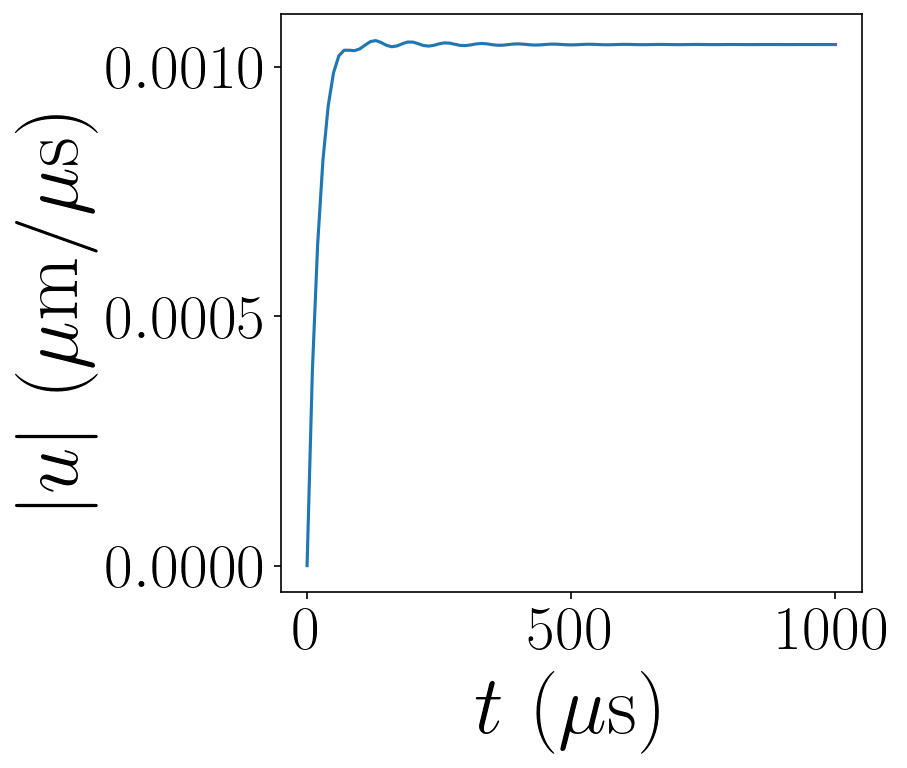

In [10]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()